In [11]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa 
import librosa.display
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [12]:
encoder=joblib.load('Encoder.joblib')
scaler=joblib.load('Scaler.joblib')

/Users/saisoorya/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 1.1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/saisoorya/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.8):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data, speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data, speed_factor)


In [14]:
#sample_rate = 22050

def extract_features(data):
    
    result = np.array([])
    
    #mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=42) #42 mfcc so we get frames of ~60 ms
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)
     
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5, res_type='kaiser_fast') 
    
    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))
    
    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))
    
    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5)) 
    
    #speed up
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))
    
    #speed down
    lower_speed_data = higher_speed(data)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))
    
    return result

features = get_features('ALL/DC_d09.wav')
check = []
for elem in features: 
    check.append(elem)        

/var/folders/qb/17cfgm351wz2s07gx63rcx0w0000gn/T/ipykernel_5566/3565566241.py:7: FutureWarning: Pass rate=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, rate)
/var/folders/qb/17cfgm351wz2s07gx63rcx0w0000gn/T/ipykernel_5566/3565566241.py:14: FutureWarning: Pass sr=22050, n_steps=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
/var/folders/qb/17cfgm351wz2s07gx63rcx0w0000gn/T/ipykernel_5566/3565566241.py:17: FutureWarning: Pass rate=1.25 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(data, speed_factor)


In [54]:
def predict(path):
    features = get_features(path)
    check = []
    for elem in features: 
        check.append(elem) 
    total_model = load_model('model123.h5')
    ans = total_model.predict(np.expand_dims(scaler.transform(features),2))
    ans = ans.mean(axis=0)
    return ans

In [55]:
ans_1 = predict('test.mp3')

In [15]:
face_model = load_model('face_model.h5')
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

2022-06-12 15:28:27.543333: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
def pred_and_plot(model, filename, class_names):
    
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[int(tf.round(pred)[0][0])]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

In [18]:
def load_and_prep_image(filename, img_shape=48):
    
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=1)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

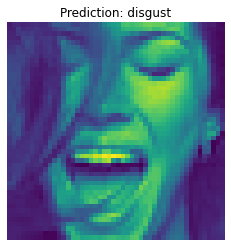

In [21]:
pred_and_plot(face_model, "test.jpeg", class_names)

In [1]:
import cv2
import numpy as np

In [44]:
cap = cv2.VideoCapture('chech1.mp4')
l = []
# Check if camera opened successfully
if (cap.isOpened()== False):
    print("Error opening video file")

# Read until video is completed
while(cap.isOpened()):

    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if(grey is not None):
        if ret == True:
            grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            grey = cv2.resize(grey, (48, 48))
            l.append(face_model.predict(tf.expand_dims(grey, axis=0)))
           
        else:
            break

In [48]:
ans_2=np.array(pd.DataFrame(np.squeeze(np.array(l))).mean(axis=0))

In [31]:
pip install ffmpeg moviepy

     |████████████████████████████████| 388 kB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 22.5 MB 13.8 MB/s eta 0:00:01
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=58b098b25322027a12435c685ad1e7d7b9a85f2080ad18c57eed224b5f836f15
  Stored in directory: /Users/saisoorya/Library/Caches/pip/wheels/1d/57/24/4eff6a03a9ea0e647568e8a5a0546cdf957e3cf005372c0245
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110744 sha256=6997c1cb77eaff3d2309f56bd32d5720ae0a1d5400818df2fcb160f19e2c3836
  Stored in directory: /Users/saisoorya/Library/Caches/pip/wheels/29/15/e4/4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
Successfully built ffmpeg moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.0
    Uninstalling decorator-5.1.0:
      Successfully uninstalled decorator-5.1.0
Note: you may need to restart the kernel to use updated packages.


In [32]:
import moviepy.editor as mp

In [35]:
my_clip = mp.VideoFileClip("chech1.mp4")
my_clip.audio.write_audiofile("test.mp3")

MoviePy - Writing audio in test.mp3


MoviePy - Done.


In [64]:
ans = ans_1 + ans_2

In [59]:
type(ans_2)

numpy.ndarray

In [56]:
ans_1

array([1.0000000e+00, 4.1492914e-18, 4.7775199e-17, 2.6477430e-15,
       1.8246120e-26, 4.3201671e-30], dtype=float32)

In [62]:
ans_2 = np. delete(ans_2, 4)

In [65]:
ans.argmax()

0